# Import libraries

In [1]:
import pandas as pd
import numpy as np
import math
import os
import sys
import networkx as nx
import json
sys.path.append("../scripts/")
from ActualADM import *
from LinearizedADM import *
from DeadlockElimination import *

# Current and parent directories

In [2]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)

# Read zone information

In [3]:
zones = pd.read_excel(str(parent_directory) + '/data/Aras-Information.xlsx', sheet_name='Zone-Info')
num_zones = len(zones)

In [4]:
adm_algo = "DBSCAN"
for house_name in ['A', 'B']:
    for occupant_id in ['1', '2']:
        for num_timeslots in range(1000, 1401, 100):
            print("Actual: House: " + str(house_name) + ", Occupant: " + str(occupant_id) + ", ADM Algo: " + str(adm_algo) + ", Number of Timeslots: " + str(num_timeslots))                  
            dataframe = pd.read_csv(str(parent_directory) + '/data/cleaned/' + 'Cleaned-Dataframe_House-' + str(house_name) + '_Occupant-' + str(occupant_id) + '.csv')                                                                                                       
            actual_adm = ActualADM(adm_algo, dataframe, house_name, occupant_id, 1440, num_zones)
            list_time_min, list_time_max = actual_adm.noise_augmented_range_calculation()
            analytics = DeadlockElimination(num_timeslots, num_zones, list_time_min, list_time_max)
            deadlock_info = analytics.deadlock_elimination()            
            output_filename = str(parent_directory) + '/data/time-limited-deadlock-elimination/Actual_' + str(adm_algo) + '_House-' + str(house_name) + '_Occupant-' + str(occupant_id) + '_Timeslots-' + str(num_timeslots) + '.json'

            with open(output_filename, "w") as json_file:
                json.dump(deadlock_info, json_file)

Actual: House: A, Occupant: 1, ADM Algo: DBSCAN, Number of Timeslots: 1000
Execution Time: 81.822092294693
Actual: House: A, Occupant: 1, ADM Algo: DBSCAN, Number of Timeslots: 1100
Execution Time: 110.04831290245056
Actual: House: A, Occupant: 1, ADM Algo: DBSCAN, Number of Timeslots: 1200
Execution Time: 113.62889218330383
Actual: House: A, Occupant: 1, ADM Algo: DBSCAN, Number of Timeslots: 1300
Execution Time: 130.31218957901
Actual: House: A, Occupant: 1, ADM Algo: DBSCAN, Number of Timeslots: 1400
Execution Time: 148.87019872665405
Actual: House: A, Occupant: 2, ADM Algo: DBSCAN, Number of Timeslots: 1000
Execution Time: 172.69453287124634
Actual: House: A, Occupant: 2, ADM Algo: DBSCAN, Number of Timeslots: 1100
Execution Time: 175.20453667640686
Actual: House: A, Occupant: 2, ADM Algo: DBSCAN, Number of Timeslots: 1200
Execution Time: 213.3835666179657
Actual: House: A, Occupant: 2, ADM Algo: DBSCAN, Number of Timeslots: 1300
Execution Time: 248.13361740112305
Actual: House: A,

In [5]:
adm_algo = "DBSCAN"
for house_name in ['A', 'B']:
    for occupant_id in ['1', '2']:
        for num_timeslots in range(1000, 1401, 100):
            start_time = time.time()
            print("Actual: House: " + str(house_name) + ", Occupant: " + str(occupant_id) + ", ADM Algo: " + str(adm_algo) + ", Number of Timeslots: " + str(num_timeslots))                  
            
            filename = str(parent_directory) + '/data/time-limited-deadlock-elimination/Actual_' + str(adm_algo) + '_House-' + str(house_name) + '_Occupant-' + str(occupant_id) + '_Timeslots-' + str(num_timeslots) + '.json'

            with open(filename, "r") as file:
                data = json.load(file)

            rewards = [0, 1, 2, 4, 3]
            states = data["States"]
            next_states = data["Next-States"]

            my_graph = nx.DiGraph()         
            for i in range(len(states)):
                state = states[i]
                arrival_time = int(state.split('-')[0])
                arrival_zone = int(state.split('-')[1])
                state_stay_duration = int(state.split('-')[2])
                try:
                    for j in next_states[str(i)]:
                        if j == -1:
                            my_graph.add_edge(state, '0-0-0', weight = 0)
                            continue

                        next_state = states[j]
                        next_arrival_time = int(next_state.split('-')[0])
                        next_arrival_zone = int(next_state.split('-')[1])
                        next_state_stay_duration = int(next_state.split('-')[2])

                        if next_arrival_zone == arrival_zone:
                            my_graph.add_edge(state, next_state, weight = (next_state_stay_duration - state_stay_duration) * rewards[arrival_zone])
                        else:
                            my_graph.add_edge(state, next_state, weight = next_state_stay_duration  * rewards[next_arrival_zone])
                except:
                    pass
            
            source_node = '0-0-0'
            
            try:
                current_source_nodes = [node for node in my_graph.nodes if my_graph.in_degree(node) == 0]

                # remove nodes whose arrival_time! = 0 and does not have any preceeding node
                nodes_to_remove = []

                for node in current_source_nodes:
                    arrival_time = int(node.split('-')[0])
                    if arrival_time != 0:
                        nodes_to_remove.append(node)

                current_source_nodes = [node for node in current_source_nodes if node not in nodes_to_remove]


                for node in current_source_nodes:
                    node_state_stay_duration = int(node.split('-')[2])
                    my_graph.add_edge(source_node, node, weight = node_state_stay_duration)

                # Get all nodes reachable from the source node
                reachable_nodes = nx.descendants(my_graph, source_node)
                reachable_nodes.add(source_node)

                # Create a subgraph containing only the reachable nodes
                my_graph = my_graph.subgraph(reachable_nodes)    

                longest_path = nx.dag_longest_path(my_graph, weight = 'weight')    
                len_longest_path = nx.dag_longest_path_length(my_graph, weight = 'weight')
                

                attack_schedule = {"Longest-Path" : longest_path, "Longest-Path-Length" : len_longest_path, "Number-of-Nodes" : my_graph.number_of_nodes(), "Number-of-Edges:" : my_graph.number_of_edges()}
            except:
                pass
            print("Number of nodes", len(states))
            print("Execution time", (time.time() - start_time) )  


Actual: House: A, Occupant: 1, ADM Algo: DBSCAN, Number of Timeslots: 1000
Number of nodes 10507
Execution time 0.3733334541320801
Actual: House: A, Occupant: 1, ADM Algo: DBSCAN, Number of Timeslots: 1100
Number of nodes 10507
Execution time 0.31031298637390137
Actual: House: A, Occupant: 1, ADM Algo: DBSCAN, Number of Timeslots: 1200
Number of nodes 14747
Execution time 0.4831838607788086
Actual: House: A, Occupant: 1, ADM Algo: DBSCAN, Number of Timeslots: 1300
Number of nodes 15098
Execution time 0.4838900566101074
Actual: House: A, Occupant: 1, ADM Algo: DBSCAN, Number of Timeslots: 1400
Number of nodes 15198
Execution time 0.43256378173828125
Actual: House: A, Occupant: 2, ADM Algo: DBSCAN, Number of Timeslots: 1000
Number of nodes 20
Execution time 0.05985307693481445
Actual: House: A, Occupant: 2, ADM Algo: DBSCAN, Number of Timeslots: 1100
Number of nodes 7197
Execution time 0.1604166030883789
Actual: House: A, Occupant: 2, ADM Algo: DBSCAN, Number of Timeslots: 1200
Number of

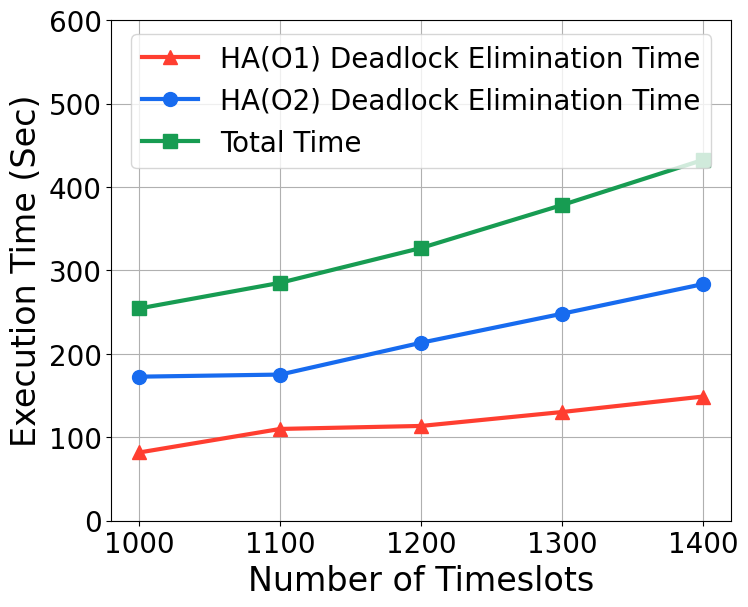

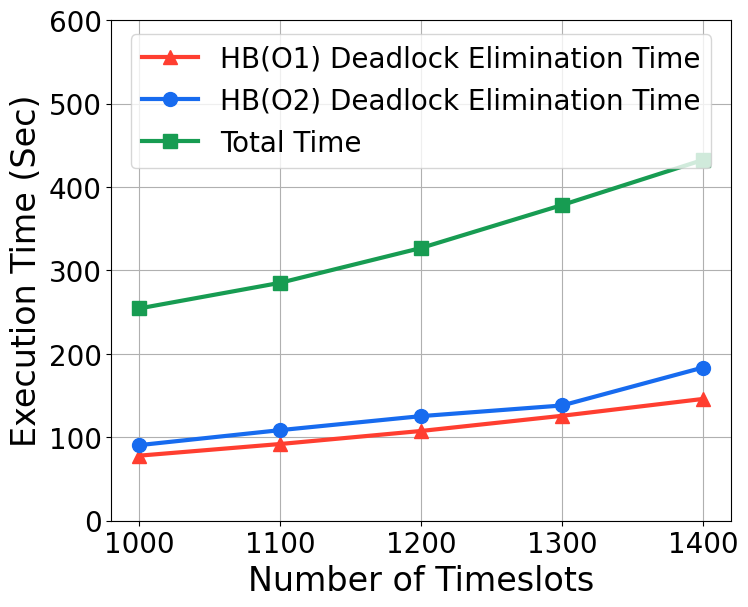

In [9]:
def plotting(occ_1_time, occ_2_time, tot_time, plotting_location, plotting_lim, saving_directory, legendlist):
    
    markers=['^','o','s']
    fig= plt.figure(figsize=(8,6.5))
    plt.plot(occ_1_time, marker = markers[0], linewidth = 3, markersize = 10, color = '#FF3E30', linestyle = '-')
    plt.plot(occ_2_time, marker = markers[1], linewidth = 3, markersize = 10, color = '#176BEF', linestyle = '-')
    plt.plot(tot_time, marker = markers[2], linewidth = 3, markersize = 10, color = '#179C52', linestyle = '-')
    plt.legend(legendlist,loc='upper center',fontsize="20")
    plt.yticks(fontsize="20")
    x = np.arange(0, 5)
    labels = [1000, 1100, 1200, 1300, 1400]
    plt.xticks(x, labels, fontsize="20")
    plt.ylim(plotting_lim)
    #plt.title(plt_title, fontsize = "16")
    plt.xlabel("Number of Timeslots", fontsize="24")
    plt.ylabel("Execution Time (Sec)", fontsize="24")
    plt.grid(True)
    plt.savefig(saving_directory, bbox_inches='tight')

house_a_occ_1 = [81.82, 110.04, 113.62, 130.31, 148.87]
house_a_occ_2 = [172.69, 175.20, 213.38, 248.13, 283.66]
house_a_tot   = [x + y for x, y in zip(house_a_occ_1, house_a_occ_2)]

house_b_occ_1 = [78.00, 91.98, 107.60, 125.80, 145.99]
house_b_occ_2 = [90.63, 108.60, 125.40, 138.16, 183.64]
house_b_tot   = [x + y for x, y in zip(house_b_occ_1, house_b_occ_2)]

plotting_location = 'upper center'
plotting_lim = [0, 600]
plotting(house_a_occ_1, house_a_occ_2, house_a_tot,  plotting_location, plotting_lim, str(parent_directory) + '/plots/Eval-4_Execution-Time_House-A_DBSCAN.pdf', ['HA(O1) Deadlock Elimination Time', 'HA(O2) Deadlock Elimination Time','Total Time'])
plotting(house_b_occ_1, house_b_occ_2, house_a_tot,  plotting_location, plotting_lim, str(parent_directory) + '/plots/Eval-4_Execution-Time_House-B_DBSCAN.pdf', ['HB(O1) Deadlock Elimination Time', 'HB(O2) Deadlock Elimination Time','Total Time'])

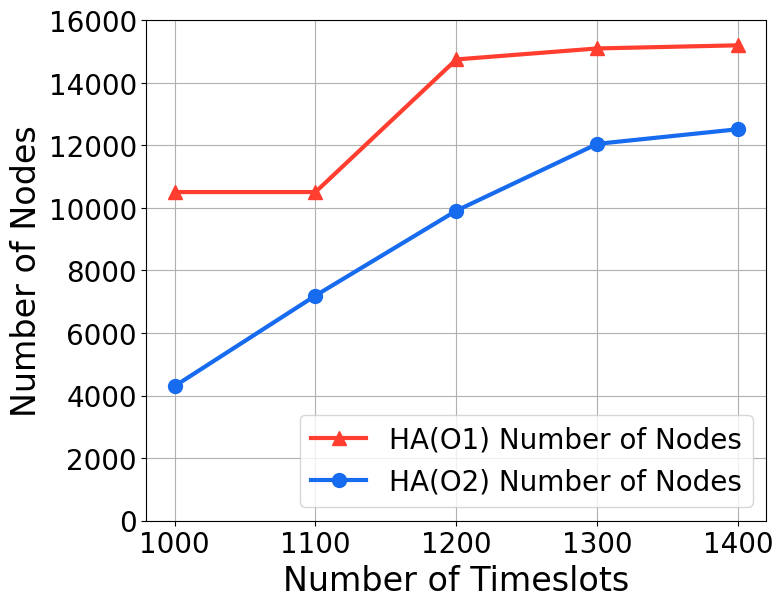

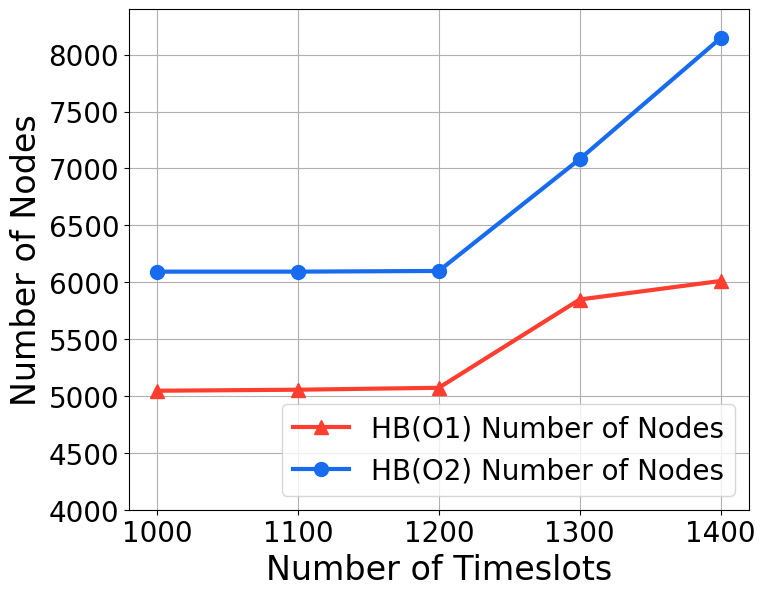

In [7]:
def plotting(occ_1_time, occ_2_time, plotting_location, plotting_lim, saving_directory, legendlist):
    
    markers=['^','o','s']
    fig= plt.figure(figsize=(8,6.5))
    plt.plot(occ_1_time, marker = markers[0], linewidth = 3, markersize = 10, color = '#FF3E30', linestyle = '-')
    plt.plot(occ_2_time, marker = markers[1], linewidth = 3, markersize = 10, color = '#176BEF', linestyle = '-')
    
    plt.legend(legendlist,loc='lower right',fontsize="20")
    plt.yticks(fontsize="20")
    x = np.arange(0, 5)
    labels = [1000, 1100, 1200, 1300, 1400]
    plt.xticks(x, labels, fontsize="20")
    plt.ylim(plotting_lim)
    #plt.title(plt_title, fontsize = "16")
    plt.xlabel("Number of Timeslots", fontsize="24")
    plt.ylabel("Number of Nodes", fontsize="24")
    plt.grid(True)
    plt.savefig(saving_directory, bbox_inches='tight')

house_a_occ_1 = [10507, 10507, 14747, 15098, 15198]
house_a_occ_2 = [4301, 7197, 9912, 12048, 12516]
house_b_occ_1 = [5046, 5055, 5072, 5848, 6011]
house_b_occ_2 = [6093, 6093, 6099, 7082, 8146]

plotting_location = 'lower center'
plotting_lim = [0, 16000]
plotting(house_a_occ_1, house_a_occ_2,  plotting_location, plotting_lim, str(parent_directory) + '/plots/Eval-4_Number-of-Nodes_House-A_DBSCAN.pdf', ['HA(O1) Number of Nodes', 'HA(O2) Number of Nodes'])
plotting_lim = [4000, 8400]
plotting(house_b_occ_1, house_b_occ_2,  plotting_location, plotting_lim, str(parent_directory) + '/plots/Eval-4_Number-of-Nodes_House-B_DBSCAN.pdf', ['HB(O1) Number of Nodes', 'HB(O2) Number of Nodes'])